# PART 2: Exploring Doctor Prevalence

Data Sources used:

Health Dataset  https://chronicdata.cdc.gov/500-Cities/500-Cities-Census-Tract-level-Data-GIS-Friendly-Fo/k25u-mg9b

Socioeconomics Dataset https://svi.cdc.gov/data-and-tools-download.html 

Better Doctor API https://developer.betterdoctor.com/documentation15 

Shapefiles of CA cities https://purl.stanford.edu/zd071bk4213

In [1]:
import geopandas as gpd
import pandas as pd
import numpy as np
import shapely as shape
import geopy.distance as gpy #install -c conda-forge geopy
import requests
import requests_cache
import matplotlib.pyplot as plt
from plotnine import *
import seaborn as sns
from random import randint
from time import sleep
requests_cache.install_cache("mycache")
pd.options.mode.chained_assignment = None  # default='warn'

import warnings
warnings.filterwarnings('ignore')

### First, we find the cities at highest and lowest risk for diabetes and mental illness. 

In [2]:
#Extract data for cities in California only
health = pd.read_csv('500_Cities__Census_Tract-level_Data__GIS_Friendly_Format___2018_release.csv')
health = health[health['StateAbbr'] == 'CA']
health.head()

,StateAbbr,PlaceName,PlaceFIPS,TractFIPS,Place_TractID,Population2010,ACCESS2_CrudePrev,ACCESS2_Crude95CI,ARTHRITIS_CrudePrev,ARTHRITIS_Crude95CI,...,PHLTH_Crude95CI,SLEEP_CrudePrev,SLEEP_Crude95CI,STROKE_CrudePrev,STROKE_Crude95CI,TEETHLOST_CrudePrev,TEETHLOST_Crude95CI,Geolocation,States,Counties
1,CA,Los Angeles,644000,6037206032,0644000-06037206032,5275,28.0,"(22.7, 33.2)",19.9,"(18.8, 20.9)",...,"(15.3, 19.2)",38.9,"(37.2, 40.4)",4.0,"( 3.5, 4.5)",18.8,"(12.6, 25.6)",POINT (-118.224698433 34.0470512474),8.0,1195.0
2,CA,Pasadena,656000,6037462001,0656000-06037462001,3974,23.3,"(19.2, 27.8)",16.7,"(16.0, 17.5)",...,"(13.9, 16.8)",40.2,"(38.8, 41.5)",3.2,"( 2.9, 3.5)",18.1,"(13.7, 22.8)",POINT (-118.143832177 34.1633689905),8.0,1195.0
3,CA,Fullerton,628000,6059011504,0628000-06059011504,5473,11.7,"( 9.6, 14.5)",8.3,"( 7.9, 8.7)",...,"( 7.7, 9.5)",33.4,"(31.6, 35.1)",1.2,"( 1.1, 1.3)",11.9,"( 8.8, 16.0)",POINT (-117.883112998 33.8820402343),8.0,1174.0
9,CA,San Diego,666000,6073003112,0666000-06073003112,4574,16.6,"(14.5, 19.0)",18.4,"(17.8, 19.0)",...,"(12.1, 14.0)",39.1,"(38.1, 40.0)",3.3,"( 3.0, 3.5)",14.5,"(11.6, 17.6)",POINT (-117.062840167 32.7058787421),8.0,1179.0
10,CA,Concord,616000,6013336102,0616000-06013336102,7595,23.7,"(19.0, 28.3)",15.1,"(14.4, 15.8)",...,"(12.8, 15.9)",38.1,"(36.4, 39.7)",2.6,"( 2.4, 2.8)",20.8,"(15.6, 26.3)",POINT (-122.039845174 37.9659371833),8.0,1185.0


In [3]:
z = health['Population2010'].reset_index()

In [4]:
#Extract health information we're interested in
health_needed = health[['Place_TractID','PlaceName','BPHIGH_CrudePrev','CASTHMA_CrudePrev','COPD_CrudePrev',
           'CSMOKING_CrudePrev','DIABETES_CrudePrev','HIGHCHOL_CrudePrev','MHLTH_CrudePrev','SLEEP_CrudePrev']]

population_total = health[['PlaceName','Population2010']]
population_total= population_total.groupby(['PlaceName']).sum().reset_index()
population_total = population_total.rename(columns = {population_total.columns[1]: "Total Population"})
population_each = health[['Place_TractID','PlaceName','Population2010']]
population_proportion = pd.merge(population_each,population_total , on = 'PlaceName')

#Calculate the population weight for each disease percentage
population_proportion['Population weight'] = population_proportion['Population2010']/population_proportion['Total Population']
population_weight = population_proportion[['Place_TractID','Population weight']]
health_needed = pd.merge(health_needed,population_weight , on = 'Place_TractID')

In [5]:
#Calculate the weighted average of each disease
for i in range(8):
    health_needed.iloc[:,i+2] = health_needed.iloc[:,i+2]*health_needed.iloc[:,10]

health_needed = health_needed.iloc[:,1:10]
health_needed['Population2010'] = z.Population2010
health_needed.head()
cityhealthcp= health_needed.groupby(['PlaceName']).sum().reset_index()

In [6]:
#Extract disease crude prevalence data
healthcp = health[['TractFIPS','PlaceName','DIABETES_CrudePrev','MHLTH_CrudePrev','SLEEP_CrudePrev', 'Population2010']]

In [7]:
#Sort cities by crude prevalence of diabetes from low to high
Diabetes = cityhealthcp.sort_values('DIABETES_CrudePrev')

In [8]:
#The 5 cities with lowest crude prevalence of diabetes are:
list(Diabetes.head(5)['PlaceName'])

['Redondo Beach', 'San Ramon', 'Berkeley', 'Folsom', 'Irvine']

In [9]:
#The 5 cities with the highest crude prevalence of diabetes are:
list(Diabetes.tail(5)['PlaceName'])

['Westminster', 'Inglewood', 'San Bernardino', 'Compton', 'Hemet']

In [10]:
#Sort cities by crude prevalence of mental illness from low to high
mental_health = cityhealthcp.sort_values('MHLTH_CrudePrev')

In [11]:
#The 5 cities with the lowest crude prevalence of mental illness are:
list(mental_health.head(5)['PlaceName'])

['San Ramon', 'Sunnyvale', 'Newport Beach', 'Fremont', 'Milpitas']

In [12]:
#The 5 cities with the highest crude prevalence of mental illness are:
list(mental_health.tail(5)['PlaceName'])

['Hesperia', 'Merced', 'Compton', 'Lynwood', 'San Bernardino']

### To find the number of doctors per city, we extract doctor prevalence by location from BetterDoctor's API. 

In [13]:
#function 
key = "a9ed2c27d2f8d4bd41631bf9922c9e82"
def find_numdoc(city):
    response = requests.get("https://api.betterdoctor.com/2016-03-01/doctors", params = {
        "location": city,
        "user_key": key
    })
    sleep(randint(0,2))
    response.raise_for_status()
    result = response.json()
    return result['meta']['total']

In [14]:
cityhealthcp['nameforapi'] = 'ca-'+ cityhealthcp['PlaceName']
doc1 = pd.DataFrame()
doc1['city'] = None

doc2 = pd.DataFrame()
doc2['city'] = None

doc3 = pd.DataFrame()
doc3['city'] = None

#betterdoctor api allows only 40 requests every minute, so separate the cities into blocks of 40 or less
for i in range(0, 40):
    doc1.loc[i,'city'] = cityhealthcp['nameforapi'][i].lower()
    doc1.loc[i,'city'] = doc1.loc[i,'city'].replace(" ",'-')
    
for i in range(40,81):
    doc2.loc[i,'city'] = cityhealthcp['nameforapi'][i].lower()
    doc2.loc[i,'city'] = doc2.loc[i,'city'].replace(" ",'-')

for i in range(81,121):
    doc3.loc[i,'city'] = cityhealthcp['nameforapi'][i].lower()
    doc3.loc[i,'city'] = doc3.loc[i,'city'].replace(" ",'-')

In [15]:
#fix name for city of ventura
doc3.loc[86, 'city'] = 'ca-ventura'

In [16]:
doc1['#doctors'] = None
doc1['#doctors'] = list(map(find_numdoc, doc1['city']))

In [17]:
doc2['#doctors'] = None
doc2['#doctors'] = list(map(find_numdoc, doc2['city']))

In [18]:
doc3['#doctors'] = None
doc3['#doctors'] = list(map(find_numdoc, doc3['city']))

In [19]:
doc = pd.concat([doc1, doc2, doc3])
doc['docs/1000'] = None
doc['docs/1000'] = doc['#doctors'] / cityhealthcp['Population2010']*1000


In [20]:
cityhealthcp.head()

,PlaceName,BPHIGH_CrudePrev,CASTHMA_CrudePrev,COPD_CrudePrev,CSMOKING_CrudePrev,DIABETES_CrudePrev,HIGHCHOL_CrudePrev,MHLTH_CrudePrev,SLEEP_CrudePrev,Population2010,nameforapi
0,Alameda,25.719995,8.287716,4.293206,11.752798,8.699557,31.329903,9.712316,33.674755,73812,ca-Alameda
1,Alhambra,27.658207,6.809047,4.142895,11.141932,11.359463,35.362469,10.124007,37.873608,83089,ca-Alhambra
2,Anaheim,25.141230,8.455059,5.181492,14.364481,10.049011,33.324204,12.417236,34.083483,336229,ca-Anaheim
3,Antioch,27.395956,9.286676,5.529028,15.701846,9.813560,33.088785,12.837886,35.896695,102372,ca-Antioch
4,Apple Valley,33.963456,10.131809,7.781888,17.060563,11.867038,38.248907,14.115668,37.846322,69103,ca-Apple Valley


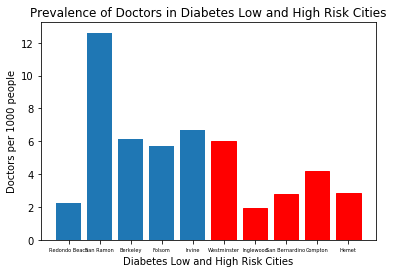

In [21]:
cities = ('ca-redondo-beach', 'ca-san-ramon','ca-berkeley', 
          'ca-folsom', 'ca-irvine','ca-westminster', 'ca-inglewood', 
          'ca-san-bernardino', 'ca-compton', 'ca-hemet')

#hi - high risk, lo - low risk
hilow = doc.loc[doc['city'].isin(cities)]

#num = pd.DataFrame()
#num['city'] = cities
#num = num.set_index('city')
hilow = hilow.set_index('city')
hilow = hilow.reindex(['ca-redondo-beach', 'ca-san-ramon','ca-berkeley', 
          'ca-folsom', 'ca-irvine','ca-westminster', 'ca-inglewood', 
          'ca-san-bernardino', 'ca-compton', 'ca-hemet'])
hilow
#num = pd.DataFrame()
#num['doc/1000'] = pd.DataFrame(list(map(find_numdoc, cities))/)
#num['city'] = ('Irvine', 'Redondo Beach', 'Murrieta', 'Chino Hills',
              #'San Ramon', 'El Monte', 'Rialto', 'Inglewood', 'Hemet',
               #'Compton')

index = np.arange(10)
b = plt.bar(index, hilow['docs/1000'])
plt.xlabel('Diabetes Low and High Risk Cities')
plt.ylabel('Doctors per 1000 people')
plt.xticks(index, ('Redondo Beach', 'San Ramon', 'Berkeley', 'Folsom', 'Irvine',
                   'Westminster', 'Inglewood', 'San Bernardino',
                   'Compton', 'Hemet'), fontsize = 5)
plt.title('Prevalence of Doctors in Diabetes Low and High Risk Cities')
b[5].set_color('r')
b[6].set_color('r')
b[7].set_color('r')
b[8].set_color('r')
b[9].set_color('r')
plt.savefig('g1.png')

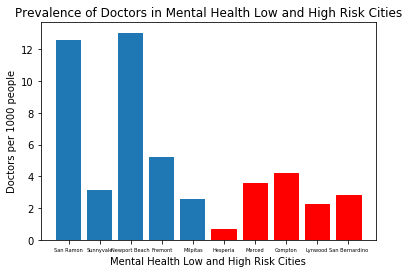

In [22]:
cities = ('ca-san-ramon', 'ca-sunnyvale', 'ca-newport-beach', 'ca-fremont', 
          'ca-milpitas', 'ca-hesperia', 'ca-merced', 'ca-compton', 'ca-lynwood',
          'ca-san-bernardino')

hilow = doc.loc[doc['city'].isin(cities)]

#num = pd.DataFrame()
#num['city'] = cities
#num = num.set_index('city')
hilow = hilow.set_index('city')
hilow = hilow.reindex(['ca-san-ramon', 'ca-sunnyvale', 'ca-newport-beach', 'ca-fremont', 
          'ca-milpitas', 'ca-hesperia', 'ca-merced', 'ca-compton', 'ca-lynwood',
          'ca-san-bernardino'])
hilow
#num = pd.DataFrame()
#num['doc/1000'] = pd.DataFrame(list(map(find_numdoc, cities))/)
#num['city'] = ('Irvine', 'Redondo Beach', 'Murrieta', 'Chino Hills',
              #'San Ramon', 'El Monte', 'Rialto', 'Inglewood', 'Hemet',
               #'Compton')

index = np.arange(10)
b = plt.bar(index, hilow['docs/1000'])
plt.xlabel('Mental Health Low and High Risk Cities')
plt.ylabel('Doctors per 1000 people')
plt.xticks(index, ('San Ramon', 'Sunnyvale', 'Newport Beach', 'Fremont',
                   'Milpitas', 'Hesperia', 'Merced', 'Compton', 'Lynwood',
                   'San Bernardino'), fontsize = 5)
plt.title('Prevalence of Doctors in Mental Health Low and High Risk Cities')
b[5].set_color('r')
b[6].set_color('r')
b[7].set_color('r')
b[8].set_color('r')
b[9].set_color('r')
plt.savefig('g2.png')

### Plot the relationship between doctors and diabetes for all cities.

In [23]:
doc['PlaceName'] = cityhealthcp['PlaceName']
health_doc = pd.merge(cityhealthcp, doc, left_on = "PlaceName", right_on = "PlaceName")

In [24]:
diabvdoc = ggplot(health_doc, aes(x = "docs/1000", y = "DIABETES_CrudePrev")) +geom_point() + geom_density_2d() + labs(title = 'Doctor Prevalence vs. Diabetes Risk for Cities', x = 'Doctors per 1000 people', y = 'Crude Prevalence of Diabetes')
diabvdoc
ggsave(diabvdoc, 'g3.png')

In [25]:
mhvdoc = ggplot(health_doc, aes(x = "docs/1000", y = "MHLTH_CrudePrev"))+geom_point() + geom_density_2d() + labs(title = 'Doctor Prevalence vs. Poor Mental Health Risk for Cities', x = 'Doctors per 1000 people', y = 'Crude Prevalence of Poor Mental Health')
ggsave(mhvdoc, 'g4.png')

# Find relationship between doctors within a certain radius and disease prevalence

In [26]:
tracts = gpd.read_file("data/Cities2015.shp")
tracts.head()

,NAME,CityType,Pop2010,Land_sqmi,DateIncorp,WebLink,County,Notes,CityAbbv,geometry
0,Benicia,City,26997,12.93,1850-03-27,http://www.ci.benicia.ca.us,Solano,None,Ben,"POLYGON ((-122.19502 38.06053, -122.19413 38.0..."
1,Vallejo,City,115942,30.67,1868-03-30,http://www.ci.vallejo.ca.us,Solano,None,Val,"MULTIPOLYGON (((-122.19573 38.15347, -122.1960..."
2,Rio Vista,City,7360,6.69,1894-01-06,http://www.ci.rio-vista.ca.us,Solano,None,RVs,"POLYGON ((-121.68572 38.15866, -121.68576 38.1..."
3,Colusa,City,5971,1.83,1868-06-16,http://www.colusa-ca.gov,Colusa,06-15-007,Clu,"MULTIPOLYGON (((-122.02677 39.18156, -122.0267..."
4,Williams,City,5123,5.44,1920-05-17,http://www.cityofwilliams.org,Colusa,None,Wms,"POLYGON ((-122.13254 39.16570, -122.13250 39.1..."


In [27]:
#social vulnerability index data from 2016
svi = gpd.read_file("SVI2016_US/SVI2016_US.shp")

In [28]:
#we join the svi data and health data at census tract level
#rename svi tract column to match column name in health
svi.rename(columns={'FIPS': 'TractFIPS'}, inplace=True)

#convert tract column to int64 type to match type in health 
svi['TractFIPS'] = svi['TractFIPS'].astype(np.int64)

In [29]:
#create new dataset from merged svi and health data
healthsvi = healthcp.merge(svi, on='TractFIPS', how='inner')
healthsvi.head()

,TractFIPS,PlaceName,DIABETES_CrudePrev,MHLTH_CrudePrev,SLEEP_CrudePrev,Population2010,ST,STATE,ST_ABBR,STCNTY,...,F_NOVEH,F_GROUPQ,F_THEME4,F_TOTAL,E_UNINSUR,M_UNINSUR,EP_UNINSUR,MP_UNINSUR,E_DAYPOP,geometry
0,6037206032,Los Angeles,15.5,15.0,38.9,5275,06,CALIFORNIA,CA,06037,...,1.0,0.0,3.0,9.0,1297.0,328.0,23.6,5.7,4816.0,"POLYGON ((-118.22870 34.05259, -118.22853 34.0..."
1,6037462001,Pasadena,11.6,15.7,40.2,3974,06,CALIFORNIA,CA,06037,...,0.0,0.0,1.0,4.0,899.0,241.0,23.0,5.7,1281.0,"POLYGON ((-118.14613 34.16888, -118.14387 34.1..."
2,6059011504,Fullerton,4.6,14.1,33.4,5473,06,CALIFORNIA,CA,06059,...,0.0,1.0,2.0,2.0,730.0,282.0,11.6,4.1,39803.0,"POLYGON ((-117.89010 33.88804, -117.88643 33.8..."
3,6073003112,San Diego,12.9,13.7,39.1,4574,06,CALIFORNIA,CA,06073,...,0.0,0.0,1.0,2.0,773.0,309.0,16.9,6.3,2949.0,"POLYGON ((-117.07309 32.70861, -117.07183 32.7..."
4,6013336102,Concord,9.5,16.4,38.1,7595,06,CALIFORNIA,CA,06013,...,0.0,0.0,2.0,5.0,1991.0,645.0,26.0,7.5,3593.0,"POLYGON ((-122.04748 37.97117, -122.04503 37.9..."


In [30]:
d = ('San Bernardino', 'Compton', 'Hemet')
b = ('Compton', 'Lynwood', 'San Bernardino')
worst3diab = healthsvi.loc[healthsvi['PlaceName'].isin(d)].reset_index()
worst3mh = healthsvi.loc[healthsvi['PlaceName'].isin(b)].reset_index()

### Using the shapefiles, we write a function to find the approximate radius of a tract.

In [31]:
#function to find the radius of a tract
def find_radius(fips):
    shape = tuple(svi.loc[svi['TractFIPS']==fips].geometry)[0]
    center = tuple(shape.centroid.coords)[0]
    # reverse (lon,lat) to (lat,lon)
    center = center[::-1]
    #create dataframe to store radiuses
    r = pd.DataFrame()
    r['rad'] = None
    #find max between center and all boundary points
    for i in range(0, len(tuple(shape.boundary.coords))):        
        bounds = tuple(shape.boundary.coords)[i]
        bounds = bounds[::-1]
        r.loc[i, 'rad'] = gpy.distance(center, bounds)
    #convert from km to miles
    radius = max(r.rad)
    convers_factor = 0.621371
    radius =  radius * convers_factor
    return radius

In [32]:
#test
find_radius(6037543100)

Distance(0.9072218364655207)

In [33]:
#get radius of census tracts for 3 cities with highest risk of diabetes
worst3diab['radius1'] = None
worst3diab['radius5'] = None
worst3diab['radius10'] = None
for i in range(0,len(worst3diab.TractFIPS)):
    try:
        worst3diab.radius1[i] = str(float(str(find_radius(worst3diab.TractFIPS[i])).replace('km',''))+1)
        worst3diab.radius5[i] = str(float(str(find_radius(worst3diab.TractFIPS[i])).replace('km',''))+5)
        worst3diab.radius10[i] = str(float(str(find_radius(worst3diab.TractFIPS[i])).replace('km',''))+10)
    except NotImplementedError:
        continue


In [34]:
#get radii of tracts in 3 highest risk cities for poor mental health
worst3mh['radius1'] = None
worst3mh['radius5'] = None
worst3mh['radius10'] = None

for i in range(0,len(worst3mh.TractFIPS)):
    try:
        worst3mh.radius1[i] = str(float(str(find_radius(worst3mh.TractFIPS[i])).replace('km',''))+1)
        worst3mh.radius5[i] = str(float(str(find_radius(worst3mh.TractFIPS[i])).replace('km',''))+5)
        worst3mh.radius10[i] = str(float(str(find_radius(worst3mh.TractFIPS[i])).replace('km',''))+10)
    except NotImplementedError:
        continue


In [35]:
#get lat, lon, and desired radius of diabetes risk cities
worst3diab['lat']=None
worst3diab['lon']=None

for i in range(0,len(worst3diab)):
    shape = worst3diab.geometry[i]
    center = tuple(shape.centroid.coords)[0]
    lat = str(center[1])
    lon = str(center[0])
    worst3diab.lat[i] = lat
    worst3diab.lon[i] = lon
    
worst3diab['apientryr1'] = worst3diab['lat']+ ',' +worst3diab['lon']+','+worst3diab['radius1']
worst3diab['apientryr5'] = worst3diab['lat']+ ',' +worst3diab['lon']+','+worst3diab['radius5']
worst3diab['apientryr10'] = worst3diab['lat']+ ',' +worst3diab['lon']+','+worst3diab['radius10']

In [36]:
#get lat, lon, and desired radius of poor mental health risk cities
worst3mh['lat']=None
worst3mh['lon']=None

for i in range(0,len(worst3mh.TractFIPS)):
    shape = worst3mh.geometry[i]
    center = tuple(shape.centroid.coords)[0]
    lat = str(center[1])
    lon = str(center[0])
    worst3mh.lat[i] = lat
    worst3mh.lon[i] = lon
    
#set columns for api entries of location data for mental health cities
worst3mh['apientryr1'] = worst3mh['lat']+ ',' +worst3mh['lon']+','+worst3mh['radius1']
worst3mh['apientryr5'] = worst3mh['lat']+ ',' +worst3mh['lon']+','+worst3mh['radius5']
worst3mh['apientryr10'] = worst3mh['lat']+ ',' +worst3mh['lon']+','+worst3mh['radius10']

### The following function extracts the number of doctors within a certain radius from the API. The individual key I used is listed.

In [37]:
key = "a9ed2c27d2f8d4bd41631bf9922c9e82"
def find_numdocrad(entry):
    response = requests.get("https://api.betterdoctor.com/2016-03-01/doctors", params = {
        "location": entry,
        "user_key": key
    })
    sleep(randint(0,4))
    response.raise_for_status()
    result = response.json()
    return result['meta']['total']

In [38]:
worst3diab['docsinr1'] = list(map(find_numdocrad, worst3diab['apientryr1']))
worst3diab['docsinr5'] = list(map(find_numdocrad, worst3diab['apientryr5']))
worst3diab['docsinr10'] = list(map(find_numdocrad, worst3diab['apientryr10']))

In [39]:
worst3diab['docsinr1/1000ppl'] = worst3diab['docsinr1'] / worst3diab['Population2010'] * 1000
worst3diab['docsinr5/1000ppl'] = worst3diab['docsinr5'] / worst3diab['Population2010'] * 1000
worst3diab['docsinr10/1000ppl'] = worst3diab['docsinr10'] / worst3diab['Population2010'] * 1000

In [40]:
#log scale number of doctors per 1000 people 
worst3diab['log_docsinr1/1000ppl'] = np.log10(worst3diab['docsinr1/1000ppl'] + 1)
worst3diab['log_docsinr5/1000ppl'] = np.log10(worst3diab['docsinr5/1000ppl'] + 1)
worst3diab['log_docsinr10/1000ppl'] = np.log10(worst3diab['docsinr10/1000ppl'] + 1)

In [41]:
worst3mh['docsinr1'] = list(map(find_numdocrad, worst3mh['apientryr1']))
worst3mh['docsinr5'] = list(map(find_numdocrad, worst3mh['apientryr5']))
worst3mh['docsinr10'] = list(map(find_numdocrad, worst3mh['apientryr10']))

In [42]:
worst3mh['docsinr1/1000ppl'] = worst3mh['docsinr1'] / worst3mh['Population2010'] * 1000
worst3mh['docsinr5/1000ppl'] = worst3mh['docsinr5'] / worst3mh['Population2010'] * 1000
worst3mh['docsinr10/1000ppl'] = worst3mh['docsinr10'] / worst3mh['Population2010'] * 1000

In [43]:
#log scale number of doctors per 1000 people 
worst3mh['log_docsinr1/1000ppl'] = np.log10(worst3mh['docsinr1/1000ppl'] + 1)
worst3mh['log_docsinr5/1000ppl'] = np.log10(worst3mh['docsinr5/1000ppl'] + 1)
worst3mh['log_docsinr10/1000ppl'] = np.log10(worst3mh['docsinr10/1000ppl'] + 1)

In [44]:
drad1 = ggplot(worst3diab, aes(x = "log_docsinr1/1000ppl", y = "DIABETES_CrudePrev")) + geom_point() + geom_density_2d() + labs(title = 'Doctors Within 1 mile vs. Diabetes Crude Prevalence', x = 'Log(Doctors within 1 mile of Tract Boundary Per 1000 People)',
     y = 'Diabetes Crude Prevalence')
ggsave(drad1, 'g5.png')

In [45]:
drad5 = ggplot(worst3diab, aes(x = "log_docsinr5/1000ppl", y = "DIABETES_CrudePrev")) + geom_point() + geom_density_2d() + labs(title = 'Doctors Within 5 miles vs. Diabetes Crude Prevalence', x = 'Log(Doctors within 5 mile of Tract Boundary Per 1000 People)',
     y = 'Diabetes Crude Prevalence')
ggsave(drad5, 'g6.png')


In [46]:
drad10 = ggplot(worst3diab, aes(x = "log_docsinr10/1000ppl", y = "DIABETES_CrudePrev")) + geom_point() + geom_density_2d() + labs(title = 'Doctors Within 10 miles vs. Diabetes Crude Prevalence', x = 'Log(Doctors within 10 mile of Tract Boundary Per 1000 People)',
     y = 'Diabetes Crude Prevalence')
ggsave(drad10, 'g7.png')

In [47]:
mrad1 = ggplot(worst3mh, aes(x = "log_docsinr1/1000ppl", y = "MHLTH_CrudePrev")) + geom_point() + geom_density_2d() + labs(title = 'Doctors Within 1 miles vs. Crude Prevalence of Poor Mental Health', x = 'Log(Doctors within 1 mile of Tract Boundary Per 1000 People)',
     y = 'Mental Health Crude Prevalence')
ggsave(mrad1, 'g8.png')


In [48]:
mrad5 = ggplot(worst3mh, aes(x = "log_docsinr5/1000ppl", y = "MHLTH_CrudePrev")) + geom_point() + geom_density_2d() + labs(title = 'Doctors Within 1 miles vs. Crude Prevalence of Poor Mental Health', x = 'Log(Doctors within 5 mile of Tract Boundary Per 1000 People)',
     y = 'Mental Health Crude Prevalence')
ggsave(mrad5, 'g9.png')

In [49]:
mrad10 = ggplot(worst3mh, aes(x = "log_docsinr10/1000ppl", y = "MHLTH_CrudePrev")) + geom_point() + geom_density_2d() + labs(title = 'Doctors Within 10 miles vs. Crude Prevalence of Poor Mental Health', x = 'Log(Doctors within 10 mile of Tract Boundary Per 1000 People)',
     y = 'Mental Health Crude Prevalence')
ggsave(mrad1, 'g10.png')